In [1]:
import argparse
import copy
import os
import sys

# Libs and helpers
from collections import OrderedDict

import numpy as np
import scipy.linalg
import tensorflow as tf

import c3.libraries.algorithms as algorithms
import c3.libraries.fidelities as fidelities
import c3.utils.qt_utils as qt_utils
from c3.utils.tf_utils import tf_project_to_comp, tf_abs, tf_unitary_overlap
import four_level_transmons.custom_gates as custom_gates
from c3.experiment import Experiment as Exp
# Main C3 objects
from c3.libraries import constants
from c3.model import Model as Mdl
from c3.optimizers.optimalcontrol import OptimalControl
from c3.parametermap import ParameterMap as PMap
from four_level_transmons.DataOutput import DataOutput
from four_level_transmons.custom_envelopes import *
from four_level_transmons.plotting import *
from four_level_transmons.utilities import *

tf.config.run_functions_eagerly(True)

2022-05-24 15:01:52.734170: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-24 15:01:52.734207: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


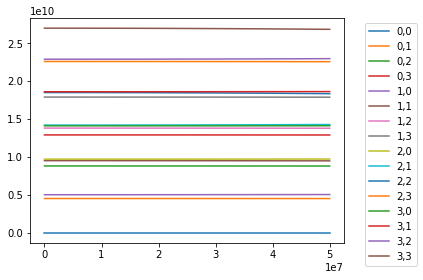

In [34]:
# main parameters
qubit_levels = [4, 4]
w1, w2 = [5e9, 4.5e9]
l1, l2 = [-300e6, -200e6]
delta = w1 - w2
w = w1 + w2

couplings = np.linspace(0, 50e6, 100)
analyticalEnergies = np.empty(shape=(16,len(couplings)))
stateLabels = []
for state in np.arange(16):
    n1 = state // 4
    n2 = state % 4
    E0 = (n1 * w1 + n2 * w2)
    E1 = 0.5 * (l1 * n1 * (n1 - 1) + l2 * n2 * (n2 - 1))
    E2 = 0
    A = (delta + l1 * (n1 + 1) - l2 * n2)
    if A != 0:
        E2 += n1 * (n2 - 1) / A
    B = delta + l1 * n1 - l2 * (n2 - 1)
    if B != 0:
        E2 -= n2 * (n1 + 1) / B
    C = w + l1 * (n1 - 1) + l2 * (n2 - 1)
    if C != 0:
        E2 += n1 * n1 / C
    D = w + l1 * n1 + l2 * n2
    if D != 0:
        E2 -= (n1 + 1) * (n2 + 1) / D
    E2 *= couplings ** 2
    analyticalEnergies[state] = (E0 + E1 + E2) * np.ones_like(couplings)
    stateLabels.append(f"{n1},{n2}")

plt.figure()
plt.plot(couplings, analyticalEnergies.T)
plt.legend(stateLabels, ncol=1, bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.tight_layout()
plt.show()

In [35]:
transitionEnergies = []
transitionLabels = []
transitionStateIndices = []
for i in range(len(stateLabels)):
    for j in range(i + 1, len(stateLabels)):
        E = analyticalEnergies[j][0] - analyticalEnergies[i][0]
        transitionEnergies.append(E)
        transitionLabels.append(stateLabels[i] + " - " + stateLabels[j])
        transitionStateIndices.append((i, j))

for i in range(len(transitionEnergies)):
    print(i, transitionLabels[i], transitionStateIndices[i], transitionEnergies[i])

0 0,0 - 0,1 (0, 1) 4500000000.0
1 0,0 - 0,2 (0, 2) 8800000000.0
2 0,0 - 0,3 (0, 3) 12900000000.0
3 0,0 - 1,0 (0, 4) 5000000000.0
4 0,0 - 1,1 (0, 5) 9500000000.0
5 0,0 - 1,2 (0, 6) 13800000000.0
6 0,0 - 1,3 (0, 7) 17900000000.0
7 0,0 - 2,0 (0, 8) 9700000000.0
8 0,0 - 2,1 (0, 9) 14200000000.0
9 0,0 - 2,2 (0, 10) 18500000000.0
10 0,0 - 2,3 (0, 11) 22600000000.0
11 0,0 - 3,0 (0, 12) 14100000000.0
12 0,0 - 3,1 (0, 13) 18600000000.0
13 0,0 - 3,2 (0, 14) 22900000000.0
14 0,0 - 3,3 (0, 15) 27000000000.0
15 0,1 - 0,2 (1, 2) 4300000000.0
16 0,1 - 0,3 (1, 3) 8400000000.0
17 0,1 - 1,0 (1, 4) 500000000.0
18 0,1 - 1,1 (1, 5) 5000000000.0
19 0,1 - 1,2 (1, 6) 9300000000.0
20 0,1 - 1,3 (1, 7) 13400000000.0
21 0,1 - 2,0 (1, 8) 5200000000.0
22 0,1 - 2,1 (1, 9) 9700000000.0
23 0,1 - 2,2 (1, 10) 14000000000.0
24 0,1 - 2,3 (1, 11) 18100000000.0
25 0,1 - 3,0 (1, 12) 9600000000.0
26 0,1 - 3,1 (1, 13) 14100000000.0
27 0,1 - 3,2 (1, 14) 18400000000.0
28 0,1 - 3,3 (1, 15) 22500000000.0
29 0,2 - 0,3 (2, 3) 410000

0 0,0 - 0,1 0.0 4500000000.0 4500000000.0
1 0,0 - 0,2 0.0 8800000000.0 8800000000.0
2 0,0 - 0,3 0.0 12900000000.0 12900000000.0
3 0,0 - 1,0 0.0 5000000000.0 5000000000.0
4 0,0 - 1,1 0.0 9500000000.0 9500000000.0
5 0,0 - 1,2 0.0 13800000000.0 13800000000.0
6 0,0 - 1,3 0.0 17900000000.0 17900000000.0
7 0,0 - 2,0 0.0 9700000000.0 9700000000.0
8 0,0 - 2,1 0.0 14200000000.0 14200000000.0
9 0,0 - 2,2 0.0 18500000000.0 18500000000.0
10 0,0 - 2,3 0.0 22600000000.0 22600000000.0
11 0,0 - 3,0 0.0 14100000000.0 14100000000.0
12 0,0 - 3,1 0.0 18600000000.0 18600000000.0
13 0,0 - 3,2 0.0 22900000000.0 22900000000.0
14 0,0 - 3,3 0.0 27000000000.0 27000000000.0
15 0,1 - 0,2 4500000000.0 8800000000.0 4300000000.0
16 0,1 - 0,3 4500000000.0 12900000000.0 8400000000.0
17 0,1 - 1,0 4500000000.0 5000000000.0 500000000.0
17 (1, 4) 0,1 - 1,0 500000000.0
18 0,1 - 1,1 4500000000.0 9500000000.0 5000000000.0
19 0,1 - 1,2 4500000000.0 13800000000.0 9300000000.0
20 0,1 - 1,3 4500000000.0 17900000000.0 13400000000.

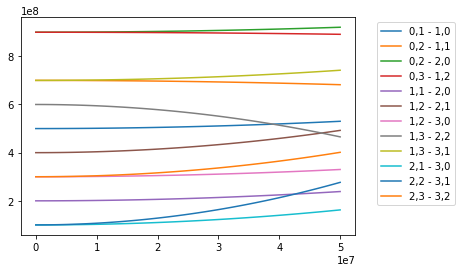

In [36]:
# Transition diagram
#selectedTransitions = [1, 26, 72, 133] #[1, 26, 49, 94, 112, 184] #[67, 101]#1, 17, 31, 58
selectedTransitions = list(range(len(transitionStateIndices)))

plt.figure()
for t in selectedTransitions:
    index = transitionStateIndices[t]
    data1 = analyticalEnergies[index[0]]
    data2 = analyticalEnergies[index[1]]
    diff = np.abs(data2 - data1)
    print(t, transitionLabels[t], data1[0], data2[0], diff[0])
    if diff[0] < 1e9:
        print(t, index, transitionLabels[t], diff[0])
        plt.plot(couplings, diff, label=transitionLabels[t])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.show()